Problem is, we should only update 'conn' and not 'wMat'

In [5]:
from neat_backprop.datagen import DataGenerator
from fineNeat.sneat_jax.ind import Ind

generator = DataGenerator(train_size=2000, batch_size=1000)
choice_id = 0
nInput = 2
nOutput = 2 

train_data, test_data = generator.generate_random_dataset(choice=choice_id)  # 0 for circle dataset

ind = Ind.from_shapes([(nInput, 5), (5, 5), (5, nOutput)], act_id=9)
ind.express()

True

In [9]:
from fineNeat.sneat_jax.ann import * 
from neat_backprop.tune import train_ind 

# For same individual, different training runs lead to different results, too 
new_ind = train_ind(child, train_data, generator, learning_rate=0.01, n_epochs=800, interval=50, nInput=2, nOutput=2)[0]

Epoch 1, Loss: 0.4521331489086151
Epoch 51, Loss: 0.338704377412796
Epoch 101, Loss: 0.2805481255054474
Epoch 151, Loss: 0.2726827561855316
Epoch 201, Loss: 0.2317592203617096
Epoch 251, Loss: 0.2141270488500595
Epoch 301, Loss: 0.18981987237930298
Epoch 351, Loss: 0.17391367256641388
Epoch 401, Loss: 0.1582333892583847
Epoch 451, Loss: 0.13486826419830322
Epoch 501, Loss: 0.1295318752527237
Epoch 551, Loss: 0.11922657489776611
Epoch 601, Loss: 0.11125533282756805
Epoch 651, Loss: 0.10585663467645645
Epoch 701, Loss: 0.10422362387180328
Epoch 751, Loss: 0.10093655437231064


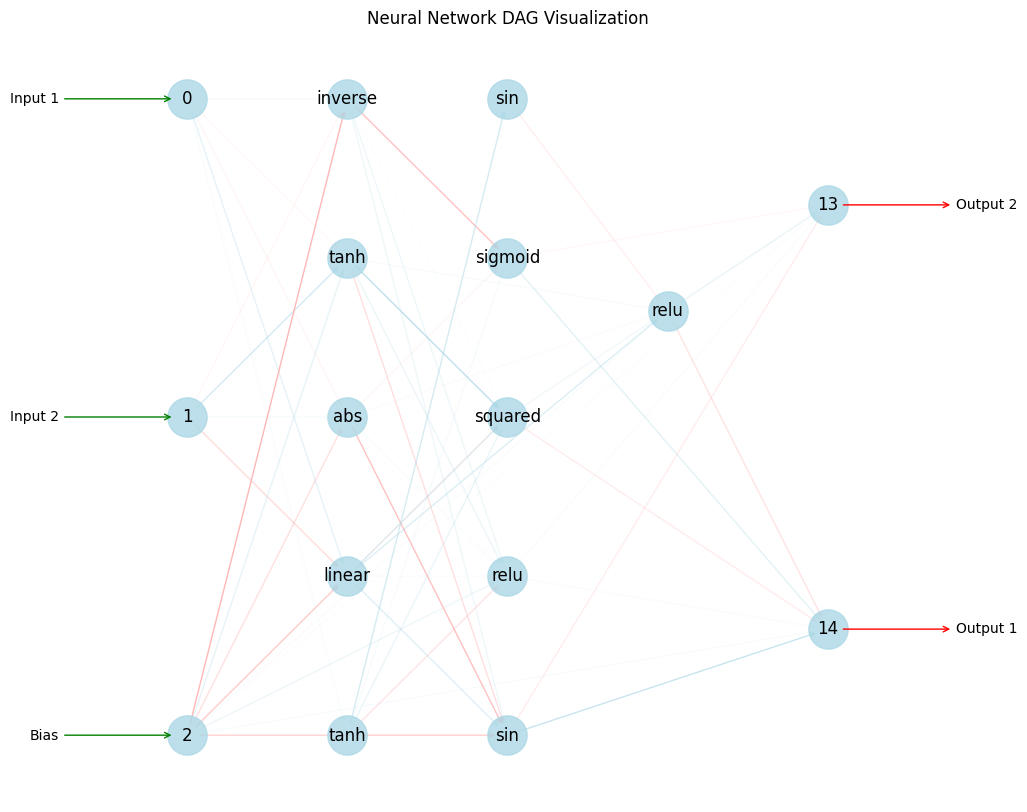

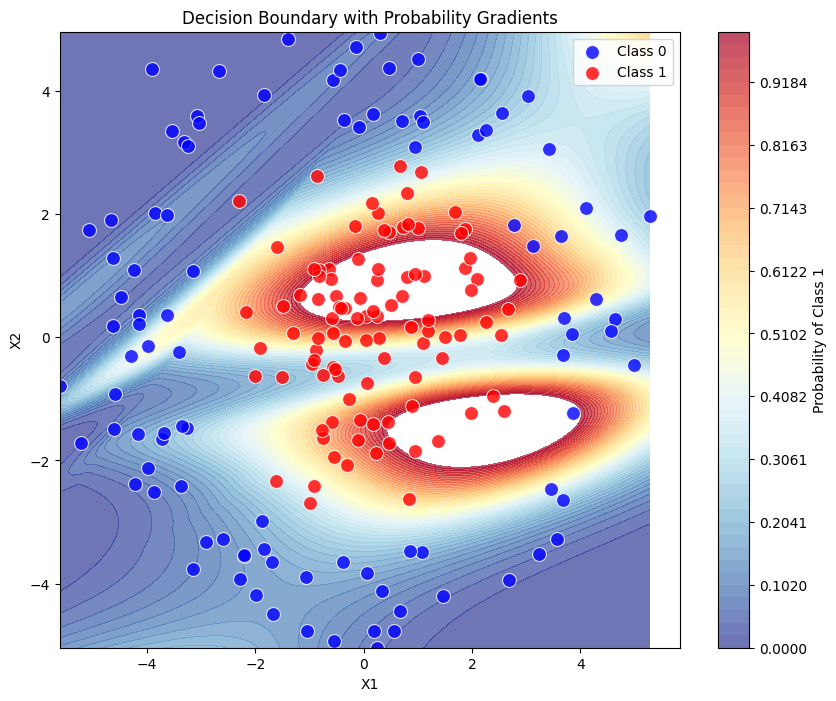

In [10]:
from fineNeat import viewInd, fig2img 
from neat_backprop.viz import plot_decision_boundary
import matplotlib.pyplot as plt

viewInd(new_ind)
fig, ax = plot_decision_boundary(new_ind.wMat, new_ind.aVec, nInput, nOutput, test_data)
img = fig2img(fig)


NEAT-backprop training on classification dataset

In [1]:
# Two Stage Training: topology search with NEAT, weight search with backprop (essentially replacing SNeat)
# - for simplicity, let's pick best few species at the end of NEAT stage, and do backprop on them, then select the best one and propagate into NEAT stage to do further search 
# - this way we reduce the workload a bit and have a more clear separation between the stages ... since we know SNeat works well for SlimeVolleyBall 


from fineNeat import Neat 
from fineNeat import loadHyp, updateHyp, load_cls_task
from neat_backprop.datagen import DataGenerator
from neat_backprop.tune import get_reward

choice_id = 0
generator = DataGenerator(train_size=2000, batch_size=1000)
train_data, test_data = generator.generate_random_dataset(choice=choice_id)  # 0 for circle dataset


hyp_default = '../fineNeat/fineNeat/p/cls.json'
hyp_adjust = '../fineNeat/fineNeat/p/cls_neat.json'
fileName = "cls"

hyp = loadHyp(pFileName=hyp_default, load_task=load_cls_task)
updateHyp(hyp,load_cls_task,hyp_adjust)

Two-Stage neat-backprop 
* Stage 1: NEAT topology search 
* Stage 2: Backprop on top individuals per species

In [7]:
from neat_backprop.tune import get_reward, jnp, train_ind
from fineNeat.sneat_jax.ind import Ind 

# Iterate 2-stage neat-backprop 
# First Stage features NEAT topology search 
neat = Neat(hyp)

neat.initPop()
for iter in range(50): 
    pop = neat.ask()
    reward = get_reward(pop, test_data, nInput=2, nOutput=2)
    print("Best reward: ", max(reward))
    neat.tell(reward)
    
best_ind = sorted(neat.pop, key=lambda x: x.fitness, reverse=True)[0]

best_ind = Ind(node=jnp.array(best_ind.node), conn=jnp.array(best_ind.conn))
best_ind.express()
best_ind, _ = train_ind(best_ind, train_data, generator, learning_rate=0.01, n_epochs=800, interval=50, nInput=2, nOutput=2)

Best reward:  0.09919971227645874
Best reward:  0.18823504447937012
 :: Cycle detected in neural network. Unprocessed nodes: {3, 4, 5}
:: Failed to express child
 :: Cycle detected in neural network. Unprocessed nodes: {5, 6}
:: Failed to express child
Best reward:  0.27660101652145386
 :: Cycle detected in neural network. Unprocessed nodes: {5, 6}
:: Failed to express child
Best reward:  0.5127767324447632
 :: Cycle detected in neural network. Unprocessed nodes: {3, 4, 6}
:: Failed to express child
Best reward:  0.5547275543212891
Best reward:  0.5783210396766663
Best reward:  0.5783210396766663
 :: Cycle detected in neural network. Unprocessed nodes: {8, 7}
:: Failed to express child
 :: Cycle detected in neural network. Unprocessed nodes: {3, 5, 6}
:: Failed to express child
Best reward:  0.5824323892593384
Best reward:  0.5785802602767944
Best reward:  0.5988928973674774
 :: Cycle detected in neural network. Unprocessed nodes: {11, 7}
:: Failed to express child
Best reward:  0.5988

In [9]:
best_ind, _ = train_ind(best_ind, train_data, generator, learning_rate=0.01, n_epochs=800, interval=50, nInput=2, nOutput=2)

Epoch 1, Loss: 0.38079991936683655
Epoch 51, Loss: 0.38852304220199585
Epoch 101, Loss: 0.3496457636356354
Epoch 151, Loss: 0.35594671964645386
Epoch 201, Loss: 0.34449103474617004
Epoch 251, Loss: 0.3535490334033966
Epoch 301, Loss: 0.3433785140514374
Epoch 351, Loss: 0.3393908143043518
Epoch 401, Loss: 0.33014243841171265
Epoch 451, Loss: 0.3316766023635864
Epoch 501, Loss: 0.3351150155067444
Epoch 551, Loss: 0.33210140466690063
Epoch 601, Loss: 0.32291117310523987
Epoch 651, Loss: 0.31993696093559265
Epoch 701, Loss: 0.3296511471271515
Epoch 751, Loss: 0.3094668388366699


(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Decision Boundary with Probability Gradients'}, xlabel='X1', ylabel='X2'>)

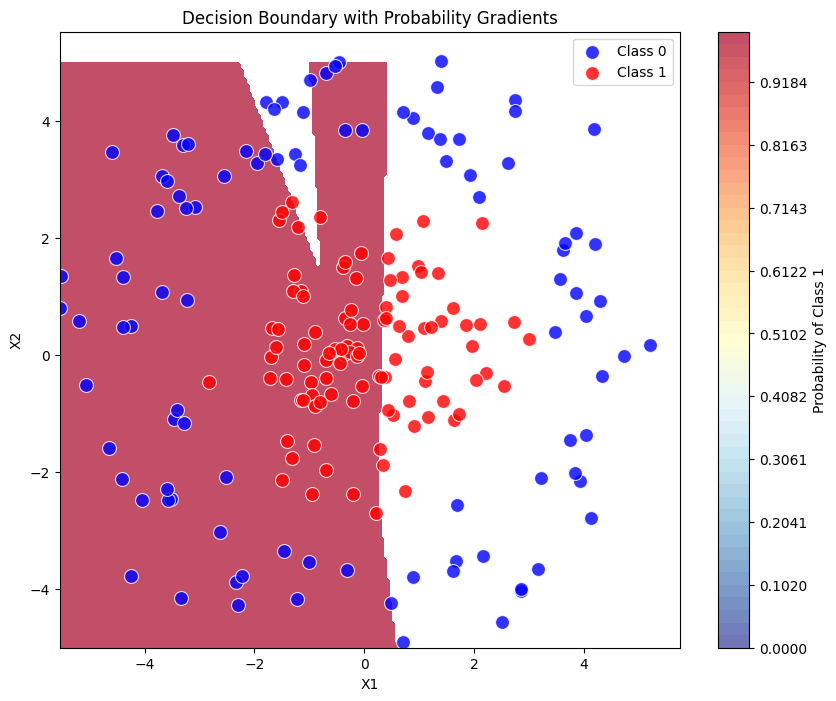

In [10]:
from neat_backprop.viz import plot_decision_boundary
plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput=2, nOutput=2, data=test_data)

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Decision Boundary with Probability Gradients'}, xlabel='X1', ylabel='X2'>)

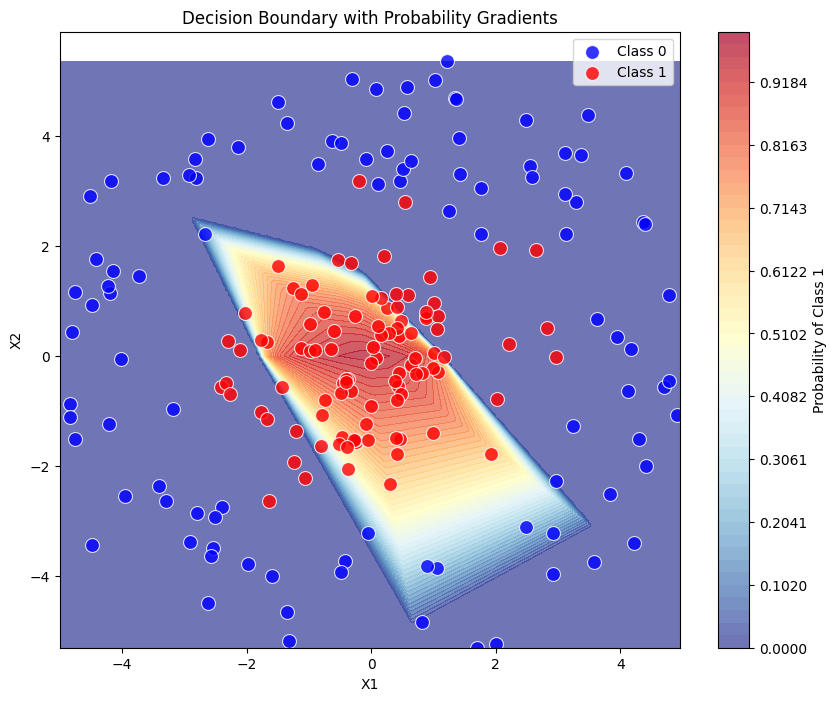

In [9]:
from fineNeat.sneat_jax.ind import Ind 

import random 
# k = nodeG.shape[1]
k = 10
random.choices([1,3,4,5,6,7,8,9,10,11], k=k)

[5, 9, 9, 6, 3, 5, 1, 11, 10, 5]

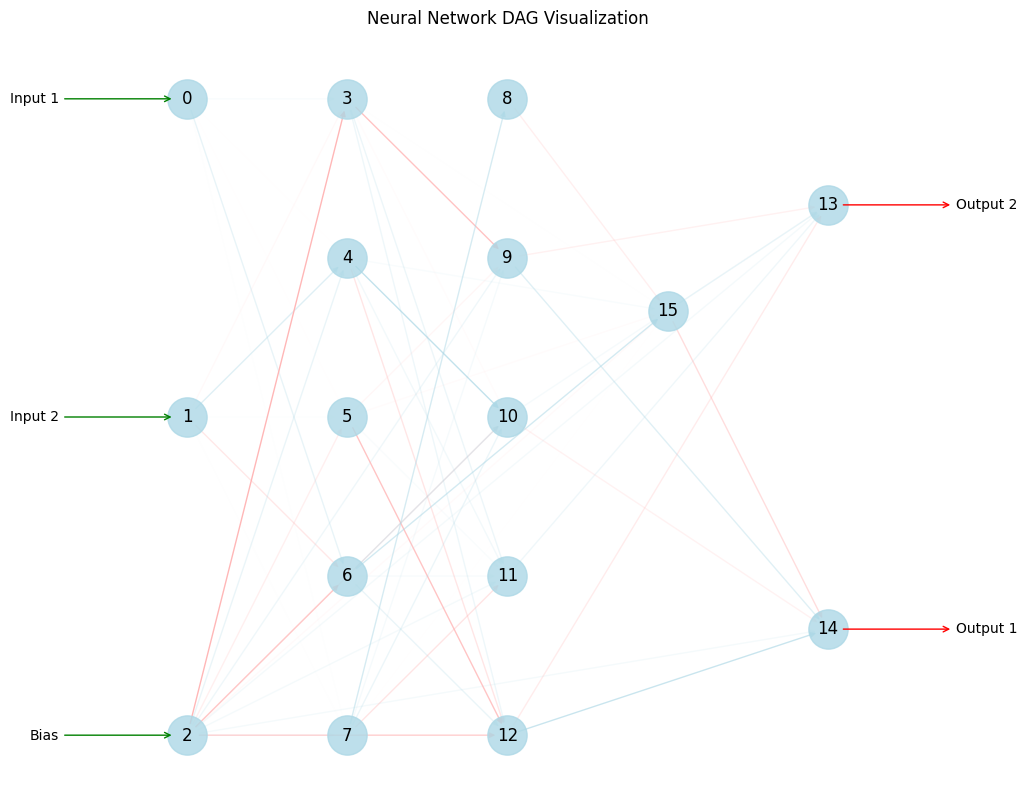

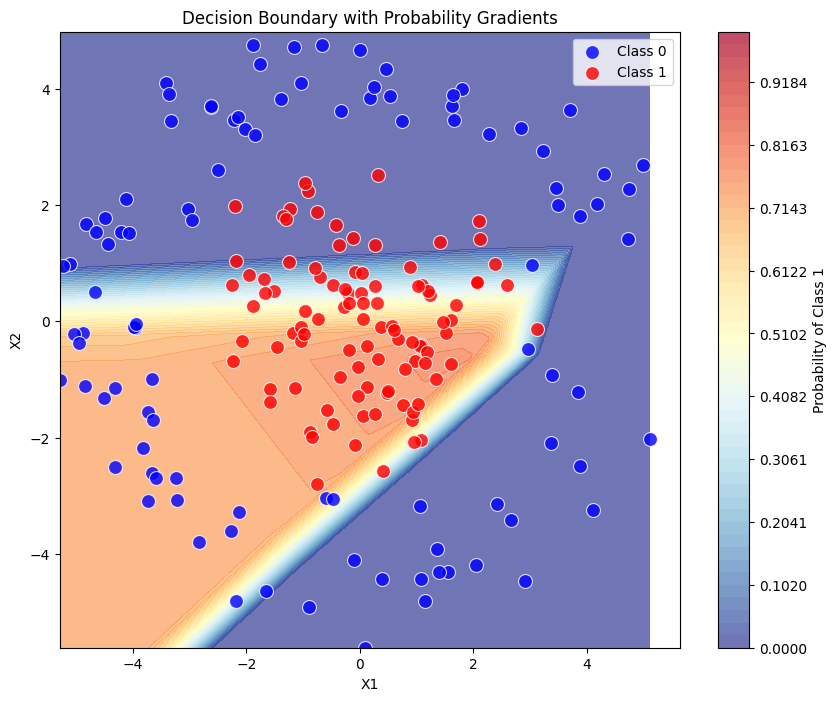

In [4]:
from fineNeat import viewInd 
viewInd(best_ind)

from viz import plot_decision_boundary
nInput, nOutput = 2, 2
plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput, nOutput, test_data)


In [7]:
fig, ax = plot_decision_boundary(best_ind.wMat, best_ind.aVec, nInput, nOutput, test_data)


NameError: name 'best_ind' is not defined